In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import shapely.geometry
import heapq
import matplotlib.animation as animation
%matplotlib widget

L1 = 0.75                    # length of first link
L2 = 0.75                    # length of second link
L3 = 0.75                    # length of second link
RESOLUTION = 100

# minRadius = L1 - L2
maxRadius = L1 + L2 + L3

tri_obstacle = [(0.4, 0.4), (1.0, 0.4), (1.5, 1.5)]
tri_obstacle2 = [(0.0, 0.6), (0.8, 0.6), (0.0, 1.5)]
quad_obstacle = [(-0.8, -0.8), (-1.0, -0.8), (-0.8, -1.2), (-1.0, -1.2)]

home = [maxRadius, 0.0]
pick = [0.0, 2.0]
place = [1.5, 0.5]

obstacles = [tri_obstacle, tri_obstacle2, quad_obstacle]

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x10d013680>>
Traceback (most recent call last):
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1450, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1138, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/

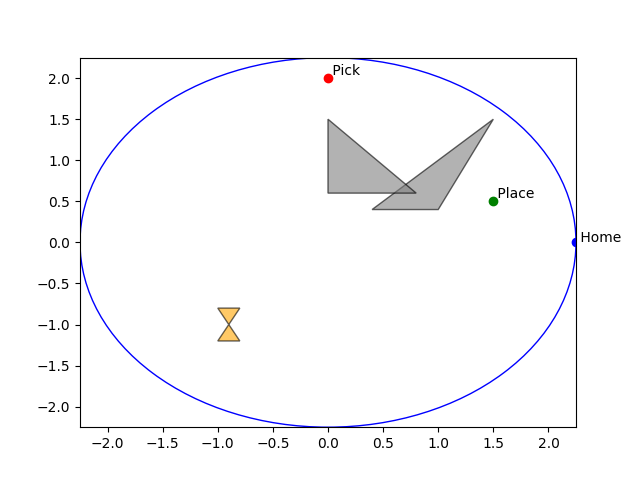

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x10d013680>>
Traceback (most recent call last):
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1450, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1138, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/

In [19]:
# Source: https://stackoverflow.com/questions/9215658/plot-a-circle-with-matplotlib-pyplot
fig , ax = plt.subplots()
ax.set_xlim(-maxRadius, maxRadius)
ax.set_ylim(-maxRadius, maxRadius)

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
# minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)

ax.add_patch(maxCircle)
# ax.add_patch(minCircle)

# --- Add obstacles as filled polygons ---
tri_patch = Polygon(tri_obstacle, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
tri_patch2 = Polygon(tri_obstacle2, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
quad_patch = Polygon(quad_obstacle, closed=True,
                     facecolor='orange', edgecolor='black', alpha=0.6)

ax.plot(pick[0], pick[1],  'ro')
ax.plot(place[0], place[1], 'go')
ax.plot(home[0], home[1], 'bo')
ax.text(pick[0], pick[1],  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place[0], place[1], ' Place', fontsize=10, va='bottom', ha='left')
ax.text(home[0], home[1], ' Home', fontsize=10)

ax.add_patch(tri_patch)
ax.add_patch(tri_patch2)
ax.add_patch(quad_patch)

plt.show()

In [20]:
def obstacle_intersection(obstacle: list[tuple[float,float]], link: tuple[tuple[float,float],tuple[float,float]]):
    polygon = shapely.geometry.Polygon(obstacle)
    line = shapely.geometry.LineString(link)

    return line.intersects(polygon)

def generate_configuration_space(obstacles: list[list[tuple[float,float]]], resolution: int  = RESOLUTION, lengths: list[float] = [L1,L2,L3]):
    """ Calculates the movement soace and obstacle space of the specific configuration
    
    Create a matrix of size (resolution X resolution) where the x and y axes are the joints variables
    and assigns a valid or invalid position value to that spot.
    Takes into account the length of the links and the obstacle space to determine if a given input
    of joint variables makes the links pass through any part of the obstacle

    Args:
        resolution (int): controls density of points to consider
        lengths (list[float]): lists the lengths of the links in the configuration
        obstacles ([tuples]): array of obstacles of tuple coordinates, creates the convex hull of all the coordinates in the list

    Returns:
        valid_config_space (matrix): matrix with valid position boolean values and associated joint variables

    """

    valid_config_space = np.zeros((resolution, resolution, resolution), dtype=bool)
    theta = np.linspace(start=0, stop=2*math.pi, num=resolution)

    for i in range(resolution):
        joint1_x = math.cos(theta[i])*lengths[0]
        joint1_y = math.sin(theta[i])*lengths[0]
        link1 = [[0.0,0.0],[joint1_x, joint1_y]]
        for j in range(resolution):
            joint2_x = joint1_x + math.cos(theta[i] + theta[j])*lengths[1]
            joint2_y = joint1_y + math.sin(theta[i] + theta[j])*lengths[1]
            link2 = [[joint1_x,joint1_y],[joint2_x,joint2_y]]
            for k in range(resolution):
                joint3_x = joint2_x + math.cos(theta[i] + theta[j] + theta[k])*lengths[2]
                joint3_y = joint2_y + math.sin(theta[i] + theta[j] + theta[k])*lengths[2]
                link3 = [[joint2_x,joint2_y],[joint3_x,joint3_y]]
                intersection = False
                for obstacle in obstacles:
                    if(obstacle_intersection(obstacle,link1) or obstacle_intersection(obstacle,link2) or obstacle_intersection(obstacle,link3)):
                        intersection = True
                valid_config_space[i][j][k] = intersection

    return valid_config_space, theta

# def is_valid(theta1: float, theta2: float, valid_config_space: np.ndarray[tuple[int, int]]):
#     theta1_index = math.floor(theta1/(2*math.pi)*RESOLUTION)
#     theta2_index = math.floor(theta2/(2*math.pi)*RESOLUTION)
#     return not valid_config_space[theta1_index][theta2_index]

def to_index(theta1: float, theta2: float, theta3: float):
    theta1_index = math.floor(theta1/(2*math.pi)*RESOLUTION)
    theta2_index = math.floor(theta2/(2*math.pi)*RESOLUTION)
    theta3_index = math.floor(theta3/(2*math.pi)*RESOLUTION)
    return [theta1_index, theta2_index, theta3_index]

# iterates through valid_config_space to find the configuration that is closest to the point
# this is because a numerical approach seems redundant since we've already done the work
# the tolerance is set by tolerance
def inverse_kinematics(x, y, L1, L2, L3, valid_config_space: np.ndarray, thetas):

    tolerance = 0.05

    def forward_kinematics (theta1, theta2, theta3, L1, L2, L3):
        x = math.cos(theta1)*L1 + math.cos(theta1 + theta2)*L2 + math.cos(theta1 + theta2 + theta3)*L3
        y = math.sin(theta1)*L1 + math.sin(theta1 + theta2)*L2 + math.sin(theta1 + theta2 + theta3)*L3
        return x, y
    
    for i in range(valid_config_space.shape[0]):
        for j in range(valid_config_space.shape[1]):
            for k in range(valid_config_space.shape[2]):
                if not valid_config_space[i][j][k]:
                    theta1 = thetas[i]
                    theta2 = thetas[j]
                    theta3 = thetas[k]
                    x_temp, y_temp = forward_kinematics(theta1, theta2, theta3, L1, L2, L3)
                    if(math.sqrt(math.pow(x_temp-x,2)+math.pow(y_temp-y,2)) < tolerance):
                    # if(abs(x_temp - x) < tolerance and y_temp - y < tolerance):
                        return theta1, theta2, theta3
    
    print("No valid configurations, returning zeros")

    return 0.0, 0.0, 0.0

In [21]:
# taken from guest lecture code
# new fucntions that allows for wrapping around and moving diagonally
def get_neighbors(pos, grid):
    neighbors = []
    # for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)
    #                    ]:
    for dx, dy, dz in [
    (-1, -1, -1), (-1, -1,  0), (-1, -1,  1),
    (-1,  0, -1),               (-1,  0,  1),
    (-1,  1, -1), (-1,  1,  0), (-1,  1,  1),

    ( 0, -1, -1), ( 0, -1,  0), ( 0, -1,  1),
    ( 0,  0, -1),               ( 0,  0,  1),
    ( 0,  1, -1), ( 0,  1,  0), ( 0,  1,  1),

    ( 1, -1, -1), ( 1, -1,  0), ( 1, -1,  1),
    ( 1,  0, -1),               ( 1,  0,  1),
    ( 1,  1, -1), ( 1,  1,  0), ( 1,  1,  1)]:
        nx, ny, nz = (pos[0] + dx)%RESOLUTION, (pos[1] + dy)%RESOLUTION, (pos[2] + dz)%RESOLUTION
        if grid[nx, ny, nz] != 1:
            neighbors.append((nx, ny, nz))
    return neighbors

# Reconstruct path from came_from dictionary
def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from.get(current)
        if current is None:
            return []  # no path found
    path.append(start)
    path.reverse()
    return path


# Dijkstra's Algorithm modified to track visited cells
def dijkstra(grid, start, goal):
    frontier = [(0, start)]
    came_from = {start: None}
    cost_so_far = {start: 0}
    visited = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        visited.add(current)
        if current == goal:
            break
        for neighbor in get_neighbors(current, grid):
            new_cost = cost_so_far[current] + 1
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                heapq.heappush(frontier, (new_cost, neighbor))
                came_from[neighbor] = current
    path = reconstruct_path(came_from, start, goal)
    return path, visited

def path_finding(grid: np.ndarray, start: list[int, int, int], end: list[int, int, int]):
    start_t = (start[0], start[1], start[2])
    end_t   = (end[0], end[1], end[2])

    path, _ = dijkstra(grid, start_t, end_t)
    return path

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x10d013680>>
Traceback (most recent call last):
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1450, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1138, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/

In [22]:
valid_config_space, theta = generate_configuration_space(obstacles)

# calucluate the theta positions of the home, pick, and place coordinates
home_theta = inverse_kinematics(home[0], home[1], L1, L2, L3, valid_config_space, theta)
pick_theta = inverse_kinematics(pick[0], pick[1], L1, L2, L3, valid_config_space, theta)
place_theta = inverse_kinematics(place[0], place[1], L1, L2, L3, valid_config_space, theta)

# create lists for each joint that will store every theta value to visit starting with the home position thetas
full_theta1 = [home_theta[0]]
full_theta2 = [home_theta[1]]
full_theta3 = [home_theta[2]]

# "index" refers to the integer grid locations in the valid_config_space, needed for the pathfinding algorithmn
# we convert the theta values to index values before applying the pathfinding algorithm
home_index = to_index(home_theta[0], home_theta[1], home_theta[2])
pick_index = to_index(pick_theta[0], pick_theta[1], pick_theta[2])
place_index = to_index(place_theta[0], place_theta[1], place_theta[2])

# find the optimal paths using start and end indices
home_to_pick_indices = path_finding(valid_config_space, home_index, pick_index)
pick_to_place_indices = path_finding(valid_config_space, pick_index, place_index)

# create temporary lists for the thetas values to get from home --> pick
theta_path1 = [theta[i] for (i, j, k) in home_to_pick_indices]
theta_path2 = [theta[j] for (i, j, k) in home_to_pick_indices]
theta_path3 = [theta[k] for (i, j, k) in home_to_pick_indices]

# add those to the running full lists that were created
full_theta1.extend(theta_path1)
full_theta2.extend(theta_path2)
full_theta3.extend(theta_path3)

#be sure to add the exact theta value for pick, might not actaully be too necessary if RESOLUTION is high enough
full_theta1.append(pick_theta[0])
full_theta2.append(pick_theta[1])
full_theta3.append(pick_theta[2])

# repeat for pick --> place
theta_path1 = [theta[i] for (i, j, k) in pick_to_place_indices]
theta_path2 = [theta[j] for (i, j, k) in pick_to_place_indices]
theta_path3 = [theta[k] for (i, j, k) in pick_to_place_indices]

full_theta1.extend(theta_path1)
full_theta2.extend(theta_path2)
full_theta3.extend(theta_path3)

full_theta1.append(place_theta[0])
full_theta2.append(place_theta[1])
full_theta3.append(place_theta[2])

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x10d013680>>
Traceback (most recent call last):
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1450, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1138, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/mason/Documents/ECE 5463/.venv/lib/python3.12/site-packages/

In [23]:
# Can't be easily visualized

# fig, ax = plt.subplots()

# ####### BELOW IS PARTIALLY FROM CHATGPT ######################

# im = ax.imshow(
#     valid_config_space.T,          # transpose so axes line up
#     origin="lower",
#     extent=[0, 2*math.pi, 0, 2*math.pi],
#     aspect="equal",
#     cmap="Greys"
# )

# ax.set_xlabel("θ1 (rad)")
# ax.set_ylabel("θ2 (rad)")

# # Plot the three configurations
# ax.plot(pick_theta[0],  pick_theta[1],  'ro')
# ax.plot(place_theta[0], place_theta[1], 'go')
# ax.plot(home_theta[0],  home_theta[1],  'bo')

# # Labels next to the points
# ax.text(pick_theta[0],  pick_theta[1],  ' Pick',  fontsize=10, va='bottom', ha='left')
# ax.text(place_theta[0], place_theta[1], ' Place', fontsize=10, va='bottom', ha='left')
# ax.text(home_theta[0],  home_theta[1],  ' Home',  fontsize=10, va='bottom', ha='left')

# ax.scatter(full_theta1, full_theta2, s=1, c='r', label='Path')
# ax.legend()

# ax.set_title("Configuration Space (white = free, black = collision)")

# plt.show()

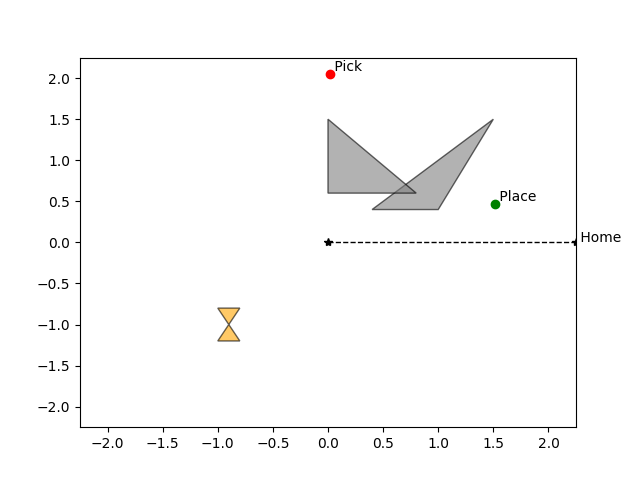

In [24]:
import matplotlib.animation as animation

fig , ax = plt.subplots()
ax.set_xlim(-maxRadius, maxRadius)
ax.set_ylim(-maxRadius, maxRadius)

# --- Add obstacles as filled polygons ---
tri_patch = Polygon(tri_obstacle, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
tri_patch2 = Polygon(tri_obstacle2, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
quad_patch = Polygon(quad_obstacle, closed=True,
                     facecolor='orange', edgecolor='black', alpha=0.6)

# ax.plot(pick[0], pick[1],  'ro')
# ax.plot(place[0], place[1], 'go')
# ax.plot(home[0], home[1], 'bo')
# ax.text(pick[0], pick[1],  ' Pick',  fontsize=10, va='bottom', ha='left')
# ax.text(place[0], place[1], ' Place', fontsize=10, va='bottom', ha='left')
# ax.text(home[0], home[1], ' Home', fontsize=10)

ax.add_patch(tri_patch)
ax.add_patch(tri_patch2)
ax.add_patch(quad_patch)

# empty arrays to fill with link positions for animation
joint1_x = []
joint1_y = []
joint2_x = []
joint2_y = []
joint3_x = []
joint3_y = []

# caluculating joint1 positions from thetas of joint 1
for theta in full_theta1:
  joint1_x.append(math.cos(theta)*L1)
  joint1_y.append(math.sin(theta)*L1)

# caluculating joint2 positions from thetas of first two joints
for i, theta in enumerate(full_theta2):
  joint2_x.append(joint1_x[i] + math.cos((theta+full_theta1[i]))*L2)
  joint2_y.append(joint1_y[i] + math.sin((theta+full_theta1[i]))*L2)

# calculating EE positions from all thetas
for i, theta in enumerate(full_theta3):
  joint3_x.append(joint2_x[i] + math.cos((theta+full_theta1[i]+full_theta2[i]))*L3)
  joint3_y.append(joint2_y[i] + math.sin((theta+full_theta1[i]+full_theta2[i]))*L3)

# calculating "forward kinematic" of pick and place positions and plotting them
pick_x = math.cos(pick_theta[0])*L1 + math.cos((pick_theta[0]+pick_theta[1]))*L2 + math.cos((pick_theta[0]+pick_theta[1]+pick_theta[2]))*L3
pick_y = math.sin(pick_theta[0])*L1 + math.sin((pick_theta[0]+pick_theta[1]))*L2 + math.sin((pick_theta[0]+pick_theta[1]+pick_theta[2]))*L3
place_x = math.cos(place_theta[0])*L1 + math.cos((place_theta[0]+place_theta[1]))*L2 + math.cos((place_theta[0]+place_theta[1]+place_theta[2]))*L3
place_y = math.sin(place_theta[0])*L1 + math.sin((place_theta[0]+place_theta[1]))*L2 + math.sin((place_theta[0]+place_theta[1]+place_theta[2]))*L3
home_x = L1 + L2 + L3
home_y = 0.0

ax.plot(pick_x, pick_y,  'ro')
ax.plot(place_x, place_y, 'go')
ax.plot([home_x,0],[0,home_y], '*--k', lw=1)
ax.text(pick_x,  pick_y,  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place_x, place_y, ' Place', fontsize=10, va='bottom', ha='left')
ax.text(home_x, home_y, ' Home', fontsize=10)

# code below taken from PA2 assignment
(l1_line,) = ax.plot([], [], lw=3)
(l2_line,) = ax.plot([], [], lw=3)
(l3_line,) = ax.plot([], [], lw=3)
# theta1_text = ax.text(0.0,0.0, '')
# theta2_text = ax.text(0.0,0.0, '')


def update(frame):
    # for each frame, update the data stored on each artist.
    x_base = 0.0
    y_base = 0.0

    x_joint1 = joint1_x[frame]
    y_joint1 = joint1_y[frame]

    x_joint2 = joint2_x[frame]
    y_joint2 = joint2_y[frame]

    x_joint3 = joint3_x[frame]
    y_joint3 = joint3_y[frame]

    # update the scatter plot:
    l1_line.set_data([x_base, x_joint1], [y_base, y_joint1])
    l2_line.set_data([x_joint1, x_joint2], [y_joint1, y_joint2])
    l3_line.set_data([x_joint2, x_joint3], [y_joint2, y_joint3])

    return l1_line, l2_line, l3_line

# interval in milliseconds, defined by the clock so the animation is in "real-time"
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(joint1_x)-1, interval=60)
plt.show()
ani.save("test_3r.mp4")